In [1]:
import pandas as pd
from sklearn import preprocessing, tree
import statistics
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pylab import rcParams
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

In [9]:
def plot_distribution(arr):
    inp = np.array(arr)
    plt.figure()
    ax = sns.distplot(inp)
    plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=5)
    _, max_ = plt.ylim()
    plt.text(
        inp.mean() + inp.mean() / 10,
        max_ - max_ / 10,
        "Mean: {:.2f}".format(inp.mean()),
    )
    return plt.figure


In [10]:
def recommend(df, model_selected, pref=''):
    if pref == "acc":
        df = df.sort_values(by=['accuracy'], ascending=False)
    elif pref == "resp":
        df = df.sort_values(by=['responsetime'], ascending=False)
    else:
        df = df.sort_values(
                by=['accuracy', 'responsetime'], ascending=(False, False)
                )

    row = df[df.model == model_selected].iloc[0] # The best we found for this model

    # Get array of system-, and hyper-parameters that gives the
    # best performance. In other words, recommend this to the user
    model = row.values[0]
    cores = row.values[1]
    ram = row.values[2]
    batch_size = row.values[3]
    learning_rate = row.values[4]
    learning_rate_decay = row.values[5]

    # print(
    #     'Better: {}-model {}-Cores {}-GBRAM {}-batchSize {}-learningRate {}-learningRateDecay'
    #     .format(
    #         model, cores, ram, batch_size, learning_rate, learning_rate_decay
    #     )
    # )
    # print(row)

    # return cores, ram, batch_size, learning_rate, learning_rate_decay, model

    #return responsetime and accuracy
    return row.values[8], row.values[7]


In [39]:

def run_with_random(df, size):
    orig_resp = []
    orig_acc = []
    rec_resp = []
    rec_acc = []
    counter = 0
    # while counter < size
    for i in range(size):
        rand = random.randrange(0, 192)
        ############################
        # Simulate a job coming in #
        ############################
        request = {
                'model': [df.iloc[[rand][0]][0]],
                'Cores': [int(df.iloc[[rand][0]][1])],  # 1 or 4
                'GBRAM': [int(df.iloc[[rand][0]][2])],  # 1 or 8
                'batchSize': [int(df.iloc[[rand][0]][3])],  # 64 or 512
                'learningRate': [float(df.iloc[[rand][0]][4])],  # 0.1 or 0.001
                'learningRateDecay': [float(df.iloc[[rand][0]][5])],  # 0.001 or 0.0001
                'status': ['slow']  # This is not needed but for removing the error
                }
        job = pd.DataFrame.from_dict(request)

        df_train = df
        df_train = df_train.append(job, sort=False)

        df_train = df_train.apply(preprocessing.LabelEncoder().fit_transform)
        df_train = df_train[
            [
                'model', 'Cores', 'GBRAM', 'batchSize', 'learningRate', 
                'learningRateDecay', 'accuracy', 'responsetime', 'status'
            ]
        ]
        df_train = df_train[:-1] # Since the incoming job is now encoded, we can remove it

        train_x = df_train.iloc[:,0:6] # features (ignore accuracy and responsetime)
        train_y = df_train.iloc[:,8]  # target_dict(request)

        # # Train a DT model on the original features
        dt = tree.DecisionTreeClassifier(max_depth=5).fit(train_x, train_y)

        # Compute the predicted labels on test data
        predicted_output = dt.predict(train_x.iloc[[-1], [0, 1, 2, 3, 4, 5]])[0]

        if predicted_output: # 1, means it's slow and needs fixing
            orig_acc.append(float(df.iloc[[1][0]][7]))
            orig_resp.append(float(df.iloc[[1][0]][8]))
            resp, acc = recommend(df, request['model'][0], "acc")
            rec_resp.append(float(resp))
            rec_acc.append(float(acc))
        else: # Already good, not need to fix it
            pass

    plot_distribution(rec_acc)
    plot_distribution(rec_resp)
    stat, p = ttest_ind(orig_resp, rec_resp)
    print("t-test resp.",stat, p)
    stat, p = ttest_ind(orig_acc, rec_acc)
    print("t-test acc.",stat, p)
    print("avg responsetime orig", statistics.mean(orig_resp))
    print("avg responsetime rec.", statistics.mean(rec_resp))
    print("avg accuracy orig.", statistics.mean(orig_acc))
    print("avg accuracy rec..", statistics.mean(rec_acc))


t-test resp. 20.438362169703975 4.654885854085604e-33
t-test acc. -8.981539782520686 1.1718996832512528e-13
avg responsetime orig 64.131226
avg responsetime rec. 60.90088085
avg accuracy orig. 0.4264
avg accuracy rec.. 0.7352974999999999


/usr/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


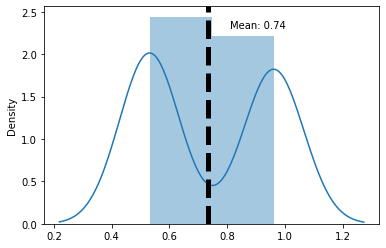

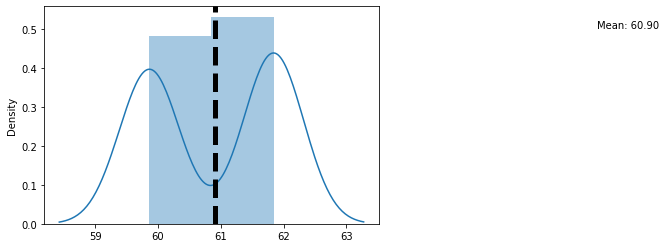

In [40]:
##################################################################################
# load the dataset, append incoming job, train and classify if job can be better #
##################################################################################
df = pd.read_csv("data_m.csv")

# run_rec_all_data(df)
run_with_random(df, 40)


In [ ]:
def run_rec_all_data(df):
    orig_resp = []
    orig_acc = []
    rec_resp = []
    rec_acc = []
    for index, row in df.iterrows():
        ############################
        # Simulate a job coming in #
        ############################
        request = {
                'model': [row[0]],
                'Cores': [int(row[1])],  # 1 or 4
                'GBRAM': [int(row[2])],  # 1 or 8
                'batchSize': [int(row[3])],  # 64 or 512
                'learningRate': [float(row[4])],  # 0.1 or 0.001
                'learningRateDecay': [float(row[5])],  # 0.001 or 0.0001
                'status': ['slow']  # This is not needed but for removing the error
                }
        job = pd.DataFrame.from_dict(request)

        df_train = df
        df_train = df_train.append(job, sort=False)

        df_train = df_train.apply(preprocessing.LabelEncoder().fit_transform)
        df_train = df_train[
            [
                'model', 'Cores', 'GBRAM', 'batchSize', 'learningRate', 
                'learningRateDecay', 'accuracy', 'responsetime', 'status'
            ]
        ]
        df_train = df_train[:-1] # Since the incoming job is now encoded, we can remove it

        train_x = df_train.iloc[:,0:6] # features (ignore accuracy and responsetime)
        train_y = df_train.iloc[:,8]  # target_dict(request)

        # # Train a DT model on the original features
        dt = tree.DecisionTreeClassifier(max_depth=5).fit(train_x, train_y)

        # Compute the predicted labels on test data
        predicted_output = dt.predict(train_x.iloc[[-1], [0, 1, 2, 3, 4, 5]])[0]

        if predicted_output: # 1, means it's slow and needs fixing
            orig_acc.append(float(row[7]))
            orig_resp.append(float(row[8]))
            resp, acc = recommend(df, request['model'][0])
            rec_resp.append(float(resp))
            rec_acc.append(float(acc))
        else: # Already good, not need to fix it
            pass

    print("avg responsetime orig", statistics.mean(orig_resp))
    print("avg responsetime rec.", statistics.mean(rec_resp))
    print("avg accuracy orig.", statistics.mean(orig_acc))
    print("avg accuracy rec..", statistics.mean(rec_acc))

